# $N_{3/2}$ - view multiple configs

In [1]:
import copy
import imageio

import subprocess
import glob

import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join as opj
import numpy as np
import healpy as hp

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})
colormap = plt.get_cmap('Spectral')
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=[colormap(k) for k in np.linspace(0, 1, 8)])


from plancklens import utils, qresp

from lenscarf.utils_hp import almxfl, alm_copy
import lenscarf
from lenscarf.run import run
from lenscarf.lerepi.visalot import plot_helper as ph

from lenscarf import n0n1_iterative
from lenscarf import cachers
from lenscarf.iterators.statics import rec as rec

def movavg(data, window=20):
    y = data
    average_y = []
    for i in range(window - 1):
        average_y.insert(0, np.nan)
    for i in range(len(y) - window + 1):
        average_y.append(np.mean(y[i:i+window]))
    return np.array(average_y)

def phi2kappa_bp(data, bpl=2, bpu=4000):
    return ph.bandpass_alms(hp.almxfl(data,np.sqrt(ll*(ll+1))), bpl, bpu)
bpl, bpu = (2,4000)

cond4mpi does not exists
could not setup healpix hack. reverting to standard healpy
MSC: using scarf with 1 OMP threads


# Results
From here, cells are built to load both, Gauss and Demnuni

In [2]:
anas_ng = []
fn = opj(os.getcwd(), 'conf_fullsky_postborn.py')
anas_ng.append(run(config=fn, job_id='MAP_lensrec', verbose=False).job)
fn = opj(os.getcwd(), 'conf_fullsky_postborn_pertmf.py')
anas_ng.append(run(config=fn, job_id='MAP_lensrec', verbose=False).job)

print([rec.maxiterdone(ana.libdir_iterators(ana.k, 0, ana.version)) for ana in anas_ng])

anas_g = []
fn = opj(os.getcwd(), 'conf_fullsky_gaussian-generic.py')
anas_g.append(run(config=fn, job_id='MAP_lensrec', verbose=False).job)
fn = opj(os.getcwd(), 'conf_fullsky_gaussian-generic_pertmf.py')
anas_g.append(run(config=fn, job_id='MAP_lensrec', verbose=False).job)

print([rec.maxiterdone(ana.libdir_iterators(ana.k, 0, ana.version)) for ana in anas_g])

i2cp = {0:'const', 1:'pert'}
cp2i = {'const':0, 'pert':1}

[15, 15]
[15, 15]


## Simulation tests

In [3]:
anas_g[0]._sims.__dict__

{'lmax': 4096,
 'dlmax': 1024,
 'nside_lens': 4096,
 'nbands': 8,
 'facres': 0,
 'unlcmbs': <plancklens.sims.cmbs.sims_cmb_unl at 0x1553e4dbb5b0>,
 'lib_dir': '/scratch/snx3000/sbelkner/sims/generic/nlevp_sqrt(2)',
 'fields': ['p', 't', 'e', 'b'],
 'offset_plm': (1, 0),
 'offset_cmb': (1, 0),
 'lens_module': <module 'lenspyx' from '/users/sbelkner/git/lenspyx/lenspyx/__init__.py'>,
 'verbose': True,
 'beam': 1.0,
 'data_type': 'map',
 'data_field': 'qu',
 'lmax_transf': 4096,
 'nlev_t': 1.0,
 'nlev_p': 1.4142135623730951,
 'nside': 2048}

In [207]:
anas_ng[1]

In [ ]:
hp.mollview(hp.alm2map(anas_g[0]._sims.get_sim_plm(0), nside=512), title='Gaussian $\phi$', cmap='YlGnBu')
hp.mollview(hp.alm2map(anas_ng[0]._sims.get_sim_plm(0), nside=512), title='Non-Gaussian $\phi$', cmap='YlGnBu')

In [5]:
data_g = hp.alm2map(anas_g[0]._sims.get_sim_plm(0),nside=2048)
data_ng = hp.alm2map(anas_ng[0]._sims.get_sim_plm(0),nside=2048)

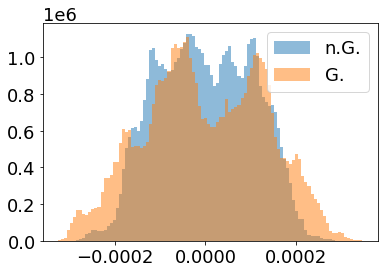

In [133]:
plt.hist(data_g, bins=100, range=(np.nanmin(data_ng),np.nanmax(data_ng)), alpha=0.5, label='n.G.')
plt.hist(data_ng, bins=100, range=(np.nanmin(data_ng),np.nanmax(data_ng)), alpha=0.5, label='G.')
plt.legend()
plt.show()

In [6]:
sim_b_g = anas_g[1]._sims.get_sim_blm(0)
sim_b_ng = anas_ng[1]._sims.get_sim_blm(0)

Text(0, 0.5, 'ratio')

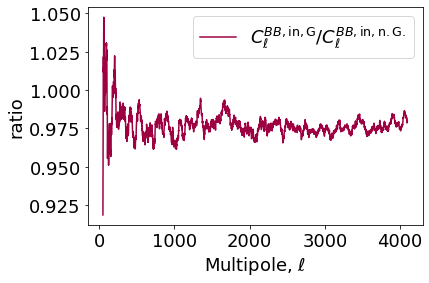

In [7]:
plt.plot(movavg(hp.alm2cl(sim_b_g)/hp.alm2cl(sim_b_ng), 50), label=r'$C_\ell^{BB, {\rm in,G}}/C_\ell^{BB, {\rm in,n.G.}}$')
plt.legend()
plt.xlabel('Multipole, $\ell$')
plt.ylabel('ratio')

## QE tests

In [8]:
plm_QE_ng = np.array([ana.get_plm_it(0, [0])[0] for ana in anas_ng])
plm_QE_g = np.array([ana.get_plm_it(0, [0])[0] for ana in anas_g])

plot_lmax = anas_g[0].qe_lm_max_qlm[0]

In [ ]:
plt.plot(hp.alm2cl(plm_QE_g[1], lmax_out=500))
plt.xscale('log')
plt.yscale('log')

In [9]:
figs = []
cpp_loc = anas_ng[0].cpp
plm_in_ng = np.array([alm_copy(ana._sims.get_sim_plm(0), 5120, ana.it_lm_max_qlm[0], ana.it_lm_max_qlm[1]) for ana in anas_ng])
plm_in_g = np.array([alm_copy(ana._sims.get_sim_plm(0), 5120, ana.it_lm_max_qlm[0], ana.it_lm_max_qlm[1]) for ana in anas_g])

R = np.array([qresp.get_response(self.k, self.lm_max_ivf[0], self.k[0], self.cls_len, self.cls_len, self.ftebl_len, lmax_qlm=self.qe_lm_max_qlm[0])[0] for self in anas_g])
WF_QE = np.array([cpp_loc * utils.cli(cpp_loc + utils.cli(R_item)) for R_item in R])

The following is $\dfrac{C_L^{\hat{\phi}\phi}}{C_L^{{\phi}\phi}W}$

In [10]:
crosspower_QE_ng = np.array([hp.alm2cl(plm_in_ng[plm_QE_itemi], plm_QE_item, lmax_out=anas_ng[plm_QE_itemi].qe_lm_max_qlm[0])/hp.alm2cl(plm_in_ng[plm_QE_itemi], lmax_out=anas_ng[plm_QE_itemi].qe_lm_max_qlm[0])/WF_QE[plm_QE_itemi] for plm_QE_itemi, plm_QE_item in enumerate(plm_QE_ng)])
crosspower_QE_g = np.array([hp.alm2cl(plm_in_g[plm_QE_itemi], plm_QE_item, lmax_out=anas_g[plm_QE_itemi].qe_lm_max_qlm[0])/hp.alm2cl(plm_in_g[plm_QE_itemi], lmax_out=anas_g[plm_QE_itemi].qe_lm_max_qlm[0])/WF_QE[plm_QE_itemi] for plm_QE_itemi, plm_QE_item in enumerate(plm_QE_g)])

and $\dfrac{C_L^{\hat{\phi}\phi}}{W}$ 

In [11]:
crosspower_QE_ng_nonorm = np.array([hp.alm2cl(plm_in_ng[plm_QE_itemi], plm_QE_item, lmax_out=anas_ng[plm_QE_itemi].qe_lm_max_qlm[0])/WF_QE[plm_QE_itemi] for plm_QE_itemi, plm_QE_item in enumerate(plm_QE_ng)])
crosspower_QE_g_nonorm = np.array([hp.alm2cl(plm_in_g[plm_QE_itemi], plm_QE_item, lmax_out=anas_g[plm_QE_itemi].qe_lm_max_qlm[0])/WF_QE[plm_QE_itemi] for plm_QE_itemi, plm_QE_item in enumerate(plm_QE_g)])

The following is $D = \dfrac{(C_L^{\hat{\phi}\phi})^2}{C_L^{{\phi}\phi}C_L^{\hat{\phi}\hat{\phi}}}$

In [12]:
deleff_QE_ng = np.array([hp.alm2cl(plm_in_ng[plm_QE_itemi], plm_QE_item, lmax_out=anas_ng[plm_QE_itemi].it_lm_max_qlm[0])**2/(hp.alm2cl(plm_QE_item, lmax_out=anas_ng[plm_QE_itemi].it_lm_max_qlm[0])*hp.alm2cl(plm_in_ng[plm_QE_itemi], lmax_out=anas_ng[plm_QE_itemi].it_lm_max_qlm[0])) for plm_QE_itemi, plm_QE_item in enumerate(plm_QE_ng)])
deleff_QE_g = np.array([hp.alm2cl(plm_in_g[plm_QE_itemi], plm_QE_item, lmax_out=anas_g[plm_QE_itemi].it_lm_max_qlm[0])**2/(hp.alm2cl(plm_QE_item, lmax_out=anas_g[plm_QE_itemi].it_lm_max_qlm[0])*hp.alm2cl(plm_in_g[plm_QE_itemi], lmax_out=anas_g[plm_QE_itemi].it_lm_max_qlm[0])) for plm_QE_itemi, plm_QE_item in enumerate(plm_QE_g)])

Text(0.5, 1.0, 'Delensing efficiency ratio')

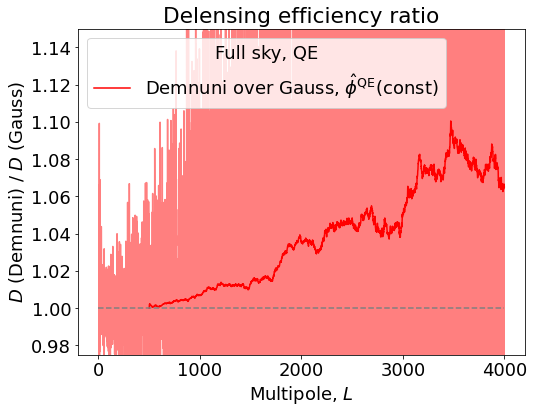

In [13]:
fig = plt.figure(figsize=(8,6))
fig.add_subplot(111)

iterator = 'const'

plt.plot(deleff_QE_ng[cp2i[iterator]]/deleff_QE_g[cp2i[iterator]], alpha=0.5, color='red')
plt.plot(movavg(deleff_QE_ng[cp2i[iterator]]/deleff_QE_g[cp2i[iterator]],500), label=r'Demnuni over Gauss, $\hat{\phi}^{\rm QE}$'+'({})'.format(iterator), color='red')
plt.ylim(0.975,1.15)
# plt.yscale('log')

plt.hlines(1,0,anas_ng[0].it_lm_max_qlm[0], color='grey', ls='--')
plt.legend(title='Full sky, QE', loc='upper left')
plt.xlabel('Multipole, $L$')
plt.ylabel(r'$D$ (Demnuni) / $D$ (Gauss)')
plt.title('Delensing efficiency ratio')

# plt.savefig('vid/frame{}.png'.format(itmax_loc-1), bbox_inches='tight')

Text(0.5, 1.0, 'ratio cross power to input')

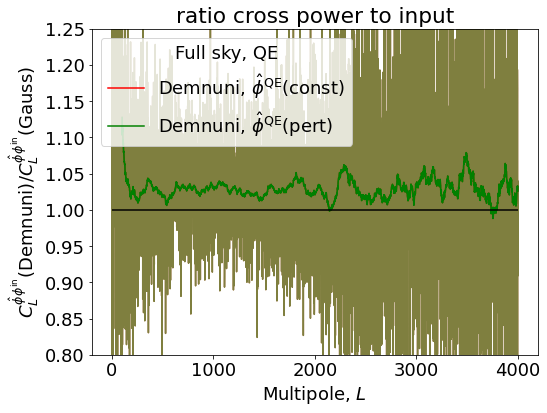

In [14]:
fig = plt.figure(figsize=(8,6))
fig.add_subplot(111)

iterator = 'const'

plt.plot(crosspower_QE_ng_nonorm[cp2i[iterator]]/crosspower_QE_g_nonorm[cp2i[iterator]], alpha=0.5, color='red')
plt.plot(movavg(crosspower_QE_ng_nonorm[cp2i[iterator]]/crosspower_QE_g_nonorm[cp2i[iterator]],100), label=r'Demnuni, $\hat{\phi}^{\rm QE}$'+'({})'.format(iterator), color='red')

iterator = 'pert'

plt.plot(crosspower_QE_ng_nonorm[cp2i[iterator]]/crosspower_QE_g_nonorm[cp2i[iterator]], alpha=0.5, color='green')
plt.plot(movavg(crosspower_QE_ng_nonorm[cp2i[iterator]]/crosspower_QE_g_nonorm[cp2i[iterator]],100), label=r'Demnuni, $\hat{\phi}^{\rm QE}$'+'({})'.format(iterator), color='green')


plt.ylim(0.8,1.25)
plt.legend(title='Full sky, QE', loc='upper left')
plt.hlines(1,0,plot_lmax, color='black')
plt.xlabel('Multipole, $L$')
plt.ylabel(r'$C_L^{\hat{\phi}\phi^{\rm in}} ({\rm Demnuni}) / C_L^{\hat{\phi}\phi^{\rm in}} ({\rm Gauss})$')
plt.title('ratio cross power to input')

Text(0.5, 1.0, 'ratio phi-normalized cross power to input')

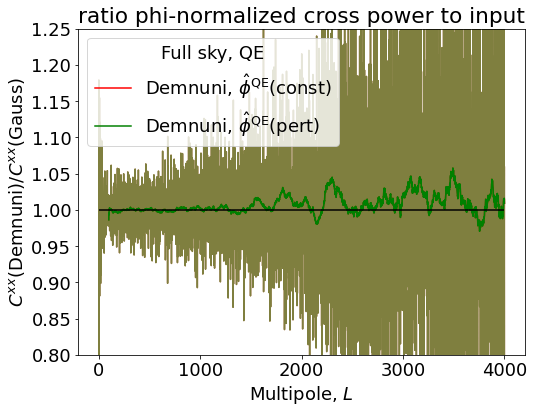

In [15]:
fig = plt.figure(figsize=(8,6))
fig.add_subplot(111)

iterator = 'const'

plt.plot(crosspower_QE_ng[cp2i[iterator]]/crosspower_QE_g[cp2i[iterator]], alpha=0.5, color='red')
plt.plot(movavg(crosspower_QE_ng[cp2i[iterator]]/crosspower_QE_g[cp2i[iterator]],100), label=r'Demnuni, $\hat{\phi}^{\rm QE}$'+'({})'.format(iterator), color='red')

iterator = 'pert'

plt.plot(crosspower_QE_ng[cp2i[iterator]]/crosspower_QE_g[cp2i[iterator]], alpha=0.5, color='green')
plt.plot(movavg(crosspower_QE_ng[cp2i[iterator]]/crosspower_QE_g[cp2i[iterator]],100), label=r'Demnuni, $\hat{\phi}^{\rm QE}$'+'({})'.format(iterator), color='green')


plt.ylim(0.8,1.25)
plt.legend(title='Full sky, QE', loc='upper left')
plt.hlines(1,0,plot_lmax, color='black')
plt.xlabel('Multipole, $L$')
plt.ylabel(r'$C^{xx} ({\rm Demnuni}) / C^{xx}({\rm Gauss})$')
plt.title('ratio phi-normalized cross power to input')

In [8]:
# import pickle
# def load_pickle(fn):
#     objects = []
#     with (open(fn, "rb")) as openfile:
#         while True:
#             try:
#                 objects.append(pickle.load(openfile))
#             except EOFError:
#                 break
#     return objects
# print(load_pickle("/scratch/snx3000/sbelkner/sims/generic/nlevp_sqrt(2)/sim_hash.pk"))
# print(load_pickle("/scratch/snx3000/sbelkner/sims/sims_postborn/nlevp_sqrt(2)/sim_hash.pk"))

[{'unl_cmbs': {'tt': '8040ff15135d15774b596a0d6c3818b0cf0f9bd8', 'ee': '80ca3f0c02755581cb239922d40fd4591af62b13', 'bb': 'ffd6e7e2b6998c1d91068c7bc0857b7916356c9d', 'te': '18662f99f5a8794a16eca2fa6f3d8817da5e84f7', 'pp': '307afa2452aed11186969f4c701ad28de47ae5a4', 'pt': 'a8182f32cd517d2d9af411e405c63e7a577af79d', 'pe': 'ad1e8cd0443ffa64a14033dbbff9342fee8e18f0', 'phas': {'nfields': 4, 'lmax': 5120}}, 'lmax': 4096, 'offset_plm': (1, 0), 'offset_cmb': (1, 0), 'nside_lens': 4096, 'facres': 0}]
[{'unl_cmbs': {'tt': '7f5861e669956d4761ac0f92142ba2ee65edf9d5', 'ee': '579a142e4f3205a7c1ca0a3bc8b5d2a770d5e25b', 'bb': 'b0078fd68e532534e7f4dfecd03dca7815779d61', 'te': '22047cd1cb6677f3704e52fdbe62a65281511bf4', 'phas': {'nfields': 3, 'lmax': 5120}}, 'lmax': 4096, 'offset_plm': (1, 0), 'offset_cmb': (1, 0), 'nside_lens': 4096, 'facres': 0}]


## MAP tests

In [16]:
# self = anas_g[1]
# print(self.TEMP)
# self.cacher_param = cachers.cacher_npy(opj(self.TEMP, 'cpplib'))

def get_N0_N1_iter(self, itermax=10, version='wE'):   
    self.config = (self.nlev_t, self.nlev_p, self._sims.beam, self.lmin_teb, self.lm_max_ivf[0], self.it_lm_max_qlm[0])
    # print(self.config)
    self.cacher_param = cachers.cacher_npy(opj(self.TEMP, 'cpplib'))
    iterbiases = n0n1_iterative.polMAPbiases(self.config, fidcls_unl=self.cls_unl, itrmax = itermax, cacher=self.cacher_param)
    N0_biased, N1_biased_spl, r_gg_fid, r_gg_true = iterbiases.get_n0n1(cls_unl_true=None, cls_noise_true=None, version=version)
    return N0_biased, N1_biased_spl, r_gg_fid, r_gg_true

In [17]:
# for self in anas_g:
#     self.cacher_param = cachers.cacher_npy(opj(self.TEMP, 'cpplib'))
#     for n in np.arange(1,anas_ng[0].itmax):
#         N0_biased, N1_biased_spl, _, _ = get_N0_N1_iter(self, n)
#         print("{} done".format(n))

In [18]:
itmax_loc = 15 #anas_g[0].itmax
assert np.all([rec.maxiterdone(ana.libdir_iterators(ana.k, 0, ana.version)) >= itmax_loc for ana in anas_g]), 'max available iteration: {}'.format([rec.maxiterdone(ana.libdir_iterators(ana.k, 0, ana.version)) for ana in anas_g])
assert np.all([rec.maxiterdone(ana.libdir_iterators(ana.k, 0, ana.version)) >= itmax_loc for ana in anas_ng]), 'max available iteration: {}'.format([rec.maxiterdone(ana.libdir_iterators(ana.k, 0, ana.version)) for ana in anas_ng])

plm_MAP_g = np.array([ana.get_plm_it(0, np.arange(itmax_loc)) for ana in anas_g])
plm_MAP_ng = np.array([ana.get_plm_it(0, np.arange(itmax_loc)) for ana in anas_ng])

In [19]:
ll = np.arange(0,anas_ng[0].qe_lm_max_qlm[0]+1,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)

## Cross-spectrum

In [20]:
plm_in_ng = np.array([alm_copy(ana._sims.get_sim_plm(0), 5120, ana.it_lm_max_qlm[0], ana.it_lm_max_qlm[1]) for ana in anas_ng])
plm_in_g = np.array([alm_copy(ana._sims.get_sim_plm(0), 5120, ana.it_lm_max_qlm[0], ana.it_lm_max_qlm[1]) for ana in anas_g])

In [21]:
# self = anas_g[0]
# cpp_loc = anas_ng[0].cpp
# self.cacher_param = cachers.cacher_npy(opj(self.TEMP, 'cpplib'))

N0, N1 = [], []
for ana in anas_ng:
    _N0, _N1, _, _ = get_N0_N1_iter(ana, itmax_loc)
    N0.append(_N0)
    N1.append(_N1)
N0 = np.array(N0)
N1 = np.array(N1)

In [22]:
WF_MAP = np.array([(ana.cpp * utils.cli(ana.cpp + N0[anai] + N1[anai]))[:ana.it_lm_max_qlm[0]+1] for anai,ana in enumerate(anas_g)])
WF_MAP.shape

(2, 4001)

The following is $C_L^{xx} = \dfrac{C_L^{\hat{\phi}\phi}}{C_L^{{\phi}\phi}W}$

In [23]:
crosspower_MAP_ng = np.array([hp.alm2cl(plm_in_ng[plm_MAP_itemi], plm_MAP_item[-1], lmax_out=anas_ng[plm_MAP_itemi].it_lm_max_qlm[0])/hp.alm2cl(plm_in_ng[0], lmax_out=anas_ng[plm_MAP_itemi].it_lm_max_qlm[0])/WF_MAP[plm_MAP_itemi] for plm_MAP_itemi, plm_MAP_item in enumerate(plm_MAP_ng)])
crosspower_MAP_g = np.array([hp.alm2cl(plm_in_g[plm_MAP_itemi], plm_MAP_item[-1], lmax_out=anas_g[plm_MAP_itemi].it_lm_max_qlm[0])/hp.alm2cl(plm_in_g[0], lmax_out=anas_g[plm_MAP_itemi].it_lm_max_qlm[0])/WF_MAP[plm_MAP_itemi] for plm_MAP_itemi, plm_MAP_item in enumerate(plm_MAP_g)])

The following is $\dfrac{C_L^{\hat{\phi}\phi}}{W}$ 

In [24]:
crosspower_MAP_ng_nonorm = np.array([hp.alm2cl(plm_in_ng[plm_MAP_itemi], plm_MAP_item[-1], lmax_out=anas_ng[plm_MAP_itemi].it_lm_max_qlm[0])/WF_MAP[plm_MAP_itemi] for plm_MAP_itemi, plm_MAP_item in enumerate(plm_MAP_ng)])
crosspower_MAP_g_nonorm = np.array([hp.alm2cl(plm_in_g[plm_MAP_itemi], plm_MAP_item[-1], lmax_out=anas_g[plm_MAP_itemi].it_lm_max_qlm[0])/WF_MAP[plm_MAP_itemi] for plm_MAP_itemi, plm_MAP_item in enumerate(plm_MAP_g)])

The following is $D = \dfrac{(C_L^{\hat{\phi}\phi})^2}{C_L^{{\phi}\phi}C_L^{\hat{\phi}\hat{\phi}}}$

In [25]:
deleff_MAP_ng = np.array([hp.alm2cl(plm_in_ng[plm_MAP_itemi], plm_MAP_item[-1], lmax_out=anas_ng[plm_MAP_itemi].it_lm_max_qlm[0])**2/(hp.alm2cl(plm_MAP_item[-1], lmax_out=anas_ng[plm_MAP_itemi].it_lm_max_qlm[0])*hp.alm2cl(plm_in_ng[0], lmax_out=anas_ng[plm_MAP_itemi].it_lm_max_qlm[0])) for plm_MAP_itemi, plm_MAP_item in enumerate(plm_MAP_ng)])
deleff_MAP_g = np.array([hp.alm2cl(plm_in_g[plm_MAP_itemi], plm_MAP_item[-1], lmax_out=anas_g[plm_MAP_itemi].it_lm_max_qlm[0])**2/(hp.alm2cl(plm_MAP_item[-1], lmax_out=anas_g[plm_MAP_itemi].it_lm_max_qlm[0])*hp.alm2cl(plm_in_g[0], lmax_out=anas_g[plm_MAP_itemi].it_lm_max_qlm[0])) for plm_MAP_itemi, plm_MAP_item in enumerate(plm_MAP_g)])

Text(0.5, 1.0, 'cross power to input')

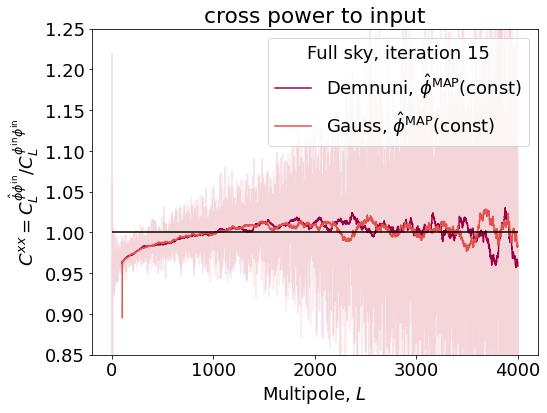

In [26]:
fig = plt.figure(figsize=(8,6))
fig.add_subplot(111)

iterator = 'const'

p = plt.plot(crosspower_MAP_ng[cp2i[iterator]], alpha=0.1)
q = plt.plot(crosspower_MAP_g[cp2i[iterator]], alpha=0.1)

plt.plot(movavg(crosspower_MAP_ng[cp2i[iterator]], 100), label=r'Demnuni, $\hat{\phi}^{\rm MAP}$'+'({})'.format(iterator), color=p[0].get_color())
plt.plot(movavg(crosspower_MAP_g[cp2i[iterator]], 100), label=r'Gauss, $\hat{\phi}^{\rm MAP}$'+'({})'.format(iterator), color=q[0].get_color())
plt.ylim(0.85,1.25)
plt.legend(title='Full sky, iteration {}'.format(itmax_loc), loc='upper right')
plt.hlines(1,0,anas_ng[0].it_lm_max_qlm[0], color='black')
plt.xlabel('Multipole, $L$')
plt.ylabel(r'$C^{xx} = C_L^{\hat{\phi}\phi^{\rm in}} / C_L^{\phi^{\rm in}\phi^{\rm in}}$')
plt.title('cross power to input')

# plt.savefig('vid/frame{}.png'.format(itmax_loc-1), bbox_inches='tight')

Text(0.5, 1.0, 'ratio cross power to input')

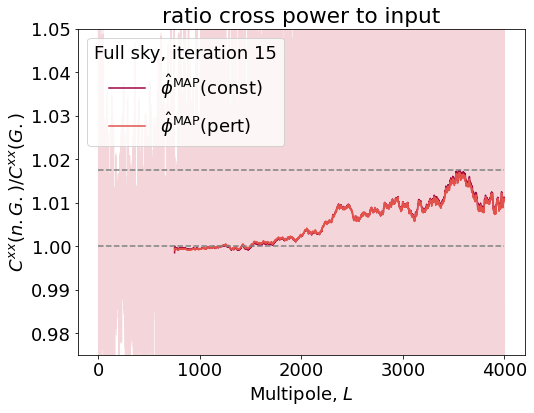

In [27]:
fig = plt.figure(figsize=(8,6))
fig.add_subplot(111)

iterator = 'const'
mx = np.nanmax(movavg(crosspower_MAP_ng[cp2i[iterator]]/crosspower_MAP_g[cp2i[iterator]],750))
p = plt.plot(crosspower_MAP_ng[cp2i[iterator]]/crosspower_MAP_g[cp2i[iterator]], alpha=0.1)
plt.plot(movavg(crosspower_MAP_ng[cp2i[iterator]]/crosspower_MAP_g[cp2i[iterator]],750), label=r'$\hat{\phi}^{\rm MAP}$'+'({})'.format(iterator), color=p[0].get_color())


iterator = 'pert'
q = plt.plot(crosspower_MAP_ng[cp2i[iterator]]/crosspower_MAP_g[cp2i[iterator]], alpha=0.1)
plt.plot(movavg(crosspower_MAP_ng[cp2i[iterator]]/crosspower_MAP_g[cp2i[iterator]],750), label=r'$\hat{\phi}^{\rm MAP}$'+'({})'.format(iterator), color=q[0].get_color())

plt.ylim(0.975,1.05)
plt.legend(title='Full sky, iteration {}'.format(itmax_loc), loc='upper left')
plt.hlines(1,0,anas_ng[0].it_lm_max_qlm[0], color='grey', ls='--')
plt.hlines(mx,0,anas_ng[0].it_lm_max_qlm[0], color='grey', ls='--')
plt.xlabel('Multipole, $L$')
plt.ylabel(r'$C^{xx} (n.G.) / C^{xx} (G.)$')
plt.title('ratio cross power to input')

# plt.savefig('vid/frame{}.png'.format(itmax_loc-1), bbox_inches='tight')

Text(0.5, 1.0, 'cross power to input')

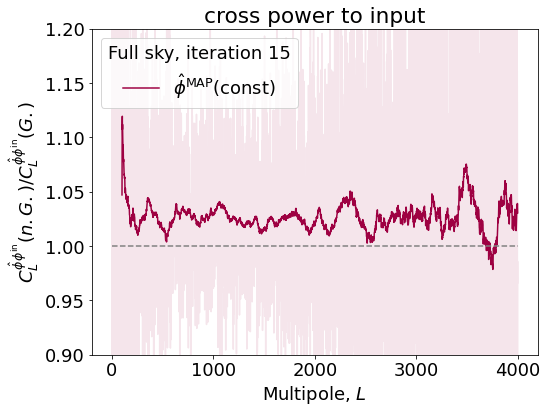

In [28]:
fig = plt.figure(figsize=(8,6))
fig.add_subplot(111)

iterator = 'const'

p = plt.plot(crosspower_MAP_ng_nonorm[cp2i[iterator]]/crosspower_MAP_g_nonorm[cp2i[iterator]], alpha=0.1)
plt.plot(movavg(crosspower_MAP_ng_nonorm[cp2i[iterator]]/crosspower_MAP_g_nonorm[cp2i[iterator]],100), label=r'$\hat{\phi}^{\rm MAP}$'+'({})'.format(iterator), color=p[0].get_color())
plt.ylim(0.9,1.2)
plt.legend(title='Full sky, iteration {}'.format(itmax_loc), loc='upper left')
plt.hlines(1,0,anas_ng[0].it_lm_max_qlm[0], color='grey', ls='--')
plt.xlabel('Multipole, $L$')
plt.ylabel(r'$C_L^{\hat{\phi}\phi^{\rm in}} (n.G.) / C_L^{\hat{\phi}\phi^{\rm in}} (G.)$')
plt.title('cross power to input')

# plt.savefig('vid/frame{}.png'.format(itmax_loc-1), bbox_inches='tight')

(1 + n3/2) / cpp ?

Text(0.5, 1.0, 'Delensing efficiency')

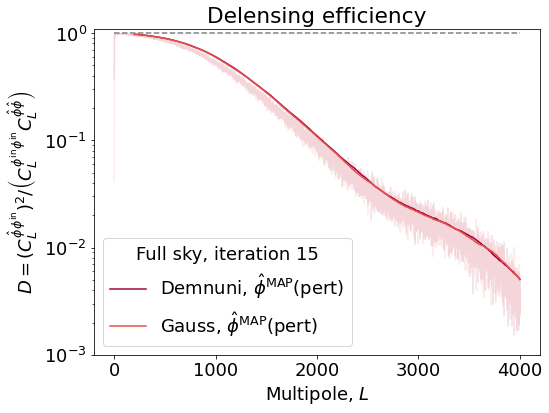

In [29]:
fig = plt.figure(figsize=(8,6))
fig.add_subplot(111)

iterator = 'pert'

p = plt.plot(deleff_MAP_ng[cp2i[iterator]], alpha=0.1)
q = plt.plot(deleff_MAP_g[cp2i[iterator]], alpha=0.1)

plt.plot(movavg(deleff_MAP_ng[cp2i[iterator]], 200), label=r'Demnuni, $\hat{\phi}^{\rm MAP}$'+'({})'.format(iterator), color=p[0].get_color())
plt.plot(movavg(deleff_MAP_g[cp2i[iterator]], 200), label=r'Gauss, $\hat{\phi}^{\rm MAP}$'+'({})'.format(iterator), color=q[0].get_color())

plt.ylim(1e-3,1.1)
plt.yscale('log')

plt.hlines(1,0,anas_ng[0].it_lm_max_qlm[0], color='grey', ls='--')
plt.legend(title='Full sky, iteration {}'.format(itmax_loc), loc='lower left')
plt.xlabel('Multipole, $L$')
plt.ylabel(r'$D = (C_L^{\hat{\phi}\phi^{\rm in}})^2 / \left( C_L^{\phi^{\rm in}\phi^{\rm in}} C_L^{\hat{\phi}\hat{\phi}}\right)$')
plt.title('Delensing efficiency')

# plt.savefig('vid/frame{}.png'.format(itmax_loc-1), bbox_inches='tight')

Text(0.5, 1.0, 'Delensing efficiency ratio')

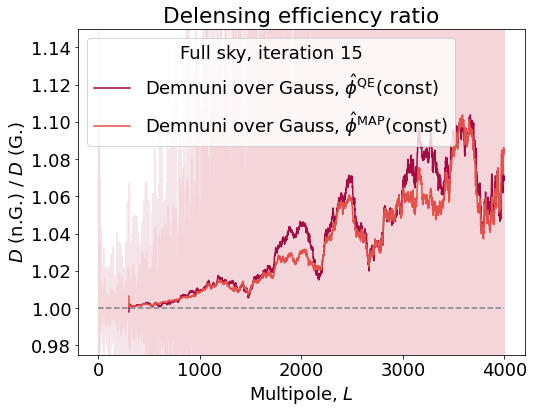

In [30]:
fig = plt.figure(figsize=(8,6))
fig.add_subplot(111)

iterator = 'const'

p = plt.plot(deleff_QE_ng[cp2i[iterator]]/deleff_QE_g[cp2i[iterator]], alpha=0.1)
plt.plot(movavg(deleff_QE_ng[cp2i[iterator]]/deleff_QE_g[cp2i[iterator]],300), label=r'Demnuni over Gauss, $\hat{\phi}^{\rm QE}$'+'({})'.format(iterator), color=p[0].get_color())

q = plt.plot(deleff_MAP_ng[cp2i[iterator]]/deleff_MAP_g[cp2i[iterator]], alpha=0.1)
plt.plot(movavg(deleff_MAP_ng[cp2i[iterator]]/deleff_MAP_g[cp2i[iterator]],300), label=r'Demnuni over Gauss, $\hat{\phi}^{\rm MAP}$'+'({})'.format(iterator), color=q[0].get_color())

plt.ylim(0.975,1.15)
# plt.yscale('log')
plt.hlines(1,0,anas_ng[0].it_lm_max_qlm[0], color='grey', ls='--')
plt.legend(title='Full sky, iteration {}'.format(itmax_loc), loc='upper left')
plt.xlabel('Multipole, $L$')
plt.ylabel(r'$D$ (n.G.) / $D$ (G.)')
plt.title('Delensing efficiency ratio')

# plt.savefig('vid/frame{}.png'.format(itmax_loc-1), bbox_inches='tight')

The above is $D = \dfrac{(C_L^{\hat{\phi}\phi})^2}{C_L^{{\phi}\phi}C_L^{\hat{\phi}\hat{\phi}}}$